In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils



import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
from numpy import arange
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import seaborn as sns

C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
epochs = 20
batch_size = 4

## Loading data

In [3]:
train_p = r'..\data\asl_data\sign_mnist_train.csv'
test_p = r'..\data\asl_data\sign_mnist_valid.csv'
train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


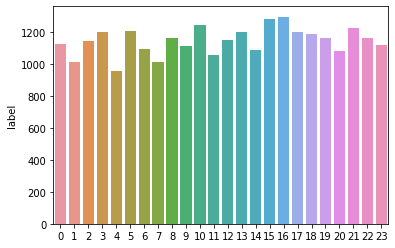

In [5]:
sns.barplot(x=train_data.label.value_counts().index, y=train_data.label.value_counts())
plt.show()

The number of data in classes are pretty balanced on the training set.

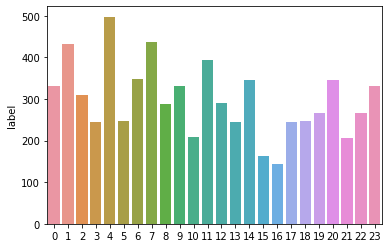

In [6]:
sns.barplot(x=test_data.label.value_counts().index, y=test_data.label.value_counts())
plt.show()

In [7]:
unq_classes = set(list(train_data['label'])+list(test_data['label']))
n_classes = len(unq_classes)
print('number of classes: ', n_classes)
print('classes: ', unq_classes)

number of classes:  24
classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


## Preparing data

In [8]:
y_train = train_data['label']
y_val = test_data['label']
del train_data['label']
del test_data['label']

X_train = train_data.values.reshape(-1,1,28,28)
X_val = test_data.values.reshape(-1,1,28,28)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_test shape: {X_val.shape}. y_test shape: {y_val.shape}')

X_train shape: (27455, 1, 28, 28). y_train shape: (27455,)
X_test shape: (7172, 1, 28, 28). y_test shape: (7172,)


### Showing some image and label examples

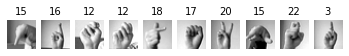

In [10]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[15:25], y_train[15:25])

### Normalize the data


In [11]:
# Exploring min and max values of image pixels
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')

X_train: min= 0, max=255


### Loading data to Dataset and Dataloader object

In [13]:
class CustomDataset():
    def __init__(self, X, Y) -> None:
        super().__init__()
        self.X = np.array(X, dtype=np.uint8)
        self.Y = Y
        # print(type(self.X), type(self.Y))


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        else:
            idx = idx
     
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))]) 
        trans_x = transform(self.X[idx]).float() 
        y = torch.tensor(self.Y[idx], dtype = torch.long)

        return trans_x, y

# passing data to the customized dataset class we created
train_datatensor = CustomDataset(X_train, y_train)
val_datatensor = CustomDataset(X_val, y_val)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )



In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([4, 28, 1, 28])
Labels batch shape: torch.Size([4])


## Creating model

In [15]:
class Net(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.n_classes = n_classes
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, self.n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1,28*28 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.softmax(x)

model= Net(n_classes = n_classes)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=24, bias=True)
  (softmax): Softmax(dim=1)
)


## Training model

In [16]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [17]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total_batches = 0
    correct_batches = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            total_batches+= 1 
            correct_batches+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct_batches / total_batches, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './asl.pth'
    if val_loss < best_loss:
        torch.save(model.state_dict(), checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




 15%|█▌        | 1032/6864 [00:06<00:35, 162.56it/s]

Step [1000/6864]: Loss = 3.178260564804077, Accuracy = 0.0


 30%|██▉       | 2027/6864 [00:12<00:31, 155.82it/s]

Step [2000/6864]: Loss = 3.177196502685547, Accuracy = 0.0


 44%|████▍     | 3024/6864 [00:18<00:22, 169.41it/s]

Step [3000/6864]: Loss = 3.1764204502105713, Accuracy = 0.25


 59%|█████▊    | 4027/6864 [00:25<00:17, 159.15it/s]

Step [4000/6864]: Loss = 3.1760828495025635, Accuracy = 0.0


 73%|███████▎  | 5016/6864 [00:31<00:10, 172.18it/s]

Step [5000/6864]: Loss = 3.1784658432006836, Accuracy = 0.0


 88%|████████▊ | 6028/6864 [00:37<00:04, 168.53it/s]

Step [6000/6864]: Loss = 3.176703929901123, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 388.07it/s]


Epoch 1/20: Train loss = 3.177039285709252, Validation loss = 3.1759320798694124, Validation accuracy: 0.2221


 15%|█▍        | 1026/6864 [00:06<00:34, 168.60it/s]

Step [1000/6864]: Loss = 3.1749675273895264, Accuracy = 0.25


 30%|██▉       | 2030/6864 [00:11<00:28, 172.05it/s]

Step [2000/6864]: Loss = 3.177096128463745, Accuracy = 0.25


 44%|████▍     | 3031/6864 [00:17<00:22, 170.30it/s]

Step [3000/6864]: Loss = 3.1654820442199707, Accuracy = 0.5


 59%|█████▊    | 4028/6864 [00:23<00:16, 169.25it/s]

Step [4000/6864]: Loss = 3.179192066192627, Accuracy = 0.0


 73%|███████▎  | 5025/6864 [00:29<00:10, 172.38it/s]

Step [5000/6864]: Loss = 3.148371934890747, Accuracy = 0.25


 88%|████████▊ | 6019/6864 [00:35<00:04, 169.23it/s]

Step [6000/6864]: Loss = 3.1749019622802734, Accuracy = 0.0


100%|██████████| 1793/1793 [00:04<00:00, 390.24it/s]


Epoch 2/20: Train loss = 3.16956432535376, Validation loss = 3.155185578192537, Validation accuracy: 0.1352


 15%|█▍        | 1021/6864 [00:06<00:39, 146.91it/s]

Step [1000/6864]: Loss = 3.143613815307617, Accuracy = 0.0


 29%|██▉       | 2023/6864 [00:14<00:35, 136.59it/s]

Step [2000/6864]: Loss = 3.18886399269104, Accuracy = 0.0


 44%|████▍     | 3015/6864 [00:21<00:28, 135.23it/s]

Step [3000/6864]: Loss = 3.217406749725342, Accuracy = 0.0


 58%|█████▊    | 4011/6864 [00:28<00:22, 128.30it/s]

Step [4000/6864]: Loss = 2.5807254314422607, Accuracy = 0.75


 73%|███████▎  | 5017/6864 [00:36<00:13, 138.72it/s]

Step [5000/6864]: Loss = 2.9584426879882812, Accuracy = 0.25


 88%|████████▊ | 6018/6864 [00:43<00:06, 140.05it/s]

Step [6000/6864]: Loss = 2.7997660636901855, Accuracy = 0.5


100%|██████████| 1793/1793 [00:06<00:00, 296.14it/s]


Epoch 3/20: Train loss = 3.0730320340269928, Validation loss = 3.0423098587816946, Validation accuracy: 0.2073


 15%|█▍        | 1020/6864 [00:07<00:41, 141.78it/s]

Step [1000/6864]: Loss = 3.2344913482666016, Accuracy = 0.0


 29%|██▉       | 2020/6864 [00:14<00:36, 133.34it/s]

Step [2000/6864]: Loss = 3.0024659633636475, Accuracy = 0.25


 44%|████▍     | 3019/6864 [00:21<00:27, 139.63it/s]

Step [3000/6864]: Loss = 2.9119725227355957, Accuracy = 0.5


 59%|█████▊    | 4025/6864 [00:28<00:19, 143.88it/s]

Step [4000/6864]: Loss = 2.771735191345215, Accuracy = 0.5


 73%|███████▎  | 5011/6864 [00:35<00:12, 142.95it/s]

Step [5000/6864]: Loss = 2.6074929237365723, Accuracy = 0.75


 88%|████████▊ | 6023/6864 [00:43<00:05, 141.66it/s]

Step [6000/6864]: Loss = 2.284456253051758, Accuracy = 1.0


100%|██████████| 1793/1793 [00:06<00:00, 296.99it/s]


Epoch 4/20: Train loss = 2.9188434960611493, Validation loss = 2.9295936348846485, Validation accuracy: 0.3376


 15%|█▍        | 1024/6864 [00:07<00:40, 144.13it/s]

Step [1000/6864]: Loss = 2.754915714263916, Accuracy = 0.5


 29%|██▉       | 2022/6864 [00:14<00:35, 135.09it/s]

Step [2000/6864]: Loss = 2.7513303756713867, Accuracy = 0.5


 44%|████▍     | 3025/6864 [00:21<00:27, 137.61it/s]

Step [3000/6864]: Loss = 2.988624095916748, Accuracy = 0.25


 58%|█████▊    | 4015/6864 [00:28<00:21, 135.56it/s]

Step [4000/6864]: Loss = 2.9894425868988037, Accuracy = 0.25


 73%|███████▎  | 5023/6864 [00:36<00:12, 143.74it/s]

Step [5000/6864]: Loss = 2.9968268871307373, Accuracy = 0.25


 88%|████████▊ | 6021/6864 [00:43<00:05, 144.17it/s]

Step [6000/6864]: Loss = 2.514732837677002, Accuracy = 0.75


100%|██████████| 1793/1793 [00:06<00:00, 284.99it/s]


Epoch 5/20: Train loss = 2.834080293461993, Validation loss = 2.9036071756600137, Validation accuracy: 0.3519


 15%|█▍        | 1027/6864 [00:06<00:32, 177.52it/s]

Step [1000/6864]: Loss = 2.5251688957214355, Accuracy = 0.75


 29%|██▉       | 2017/6864 [00:12<00:28, 171.13it/s]

Step [2000/6864]: Loss = 2.746953010559082, Accuracy = 0.5


 44%|████▍     | 3016/6864 [00:18<00:21, 175.66it/s]

Step [3000/6864]: Loss = 2.748861312866211, Accuracy = 0.5


 59%|█████▊    | 4030/6864 [00:23<00:15, 183.49it/s]

Step [4000/6864]: Loss = 2.5027077198028564, Accuracy = 0.75


 73%|███████▎  | 5027/6864 [00:29<00:10, 179.66it/s]

Step [5000/6864]: Loss = 2.9864540100097656, Accuracy = 0.25


 88%|████████▊ | 6016/6864 [00:34<00:04, 174.54it/s]

Step [6000/6864]: Loss = 2.752793073654175, Accuracy = 0.5


100%|██████████| 1793/1793 [00:04<00:00, 416.97it/s]


Epoch 6/20: Train loss = 2.7997228909275194, Validation loss = 2.8801127186183217, Validation accuracy: 0.3731


 15%|█▍        | 1020/6864 [00:05<00:33, 175.58it/s]

Step [1000/6864]: Loss = 3.0008044242858887, Accuracy = 0.25


 30%|██▉       | 2029/6864 [00:11<00:26, 183.42it/s]

Step [2000/6864]: Loss = 2.990562677383423, Accuracy = 0.25


 44%|████▍     | 3026/6864 [00:17<00:21, 178.20it/s]

Step [3000/6864]: Loss = 3.082789421081543, Accuracy = 0.25


 59%|█████▊    | 4025/6864 [00:23<00:17, 166.60it/s]

Step [4000/6864]: Loss = 2.7529726028442383, Accuracy = 0.5


 73%|███████▎  | 5030/6864 [00:29<00:11, 164.82it/s]

Step [5000/6864]: Loss = 2.993105411529541, Accuracy = 0.25


 88%|████████▊ | 6023/6864 [00:35<00:04, 180.04it/s]

Step [6000/6864]: Loss = 2.9894633293151855, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 416.56it/s]


Epoch 7/20: Train loss = 2.7739466850087915, Validation loss = 2.871501824341203, Validation accuracy: 0.3773


 15%|█▍        | 1021/6864 [00:05<00:29, 194.85it/s]

Step [1000/6864]: Loss = 3.1414854526519775, Accuracy = 0.0


 30%|██▉       | 2029/6864 [00:10<00:25, 188.61it/s]

Step [2000/6864]: Loss = 2.74737548828125, Accuracy = 0.5


 44%|████▍     | 3020/6864 [00:15<00:20, 186.24it/s]

Step [3000/6864]: Loss = 2.497142791748047, Accuracy = 0.75


 59%|█████▊    | 4026/6864 [00:21<00:14, 196.82it/s]

Step [4000/6864]: Loss = 2.4986212253570557, Accuracy = 0.75


 73%|███████▎  | 5019/6864 [00:26<00:09, 191.56it/s]

Step [5000/6864]: Loss = 2.7451014518737793, Accuracy = 0.5


 88%|████████▊ | 6031/6864 [00:31<00:04, 191.73it/s]

Step [6000/6864]: Loss = 2.9860167503356934, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 423.65it/s]


Epoch 8/20: Train loss = 2.76596802351497, Validation loss = 2.8700805444392956, Validation accuracy: 0.3788


 15%|█▌        | 1031/6864 [00:05<00:30, 188.27it/s]

Step [1000/6864]: Loss = 2.9907987117767334, Accuracy = 0.25


 29%|██▉       | 2022/6864 [00:11<00:32, 147.74it/s]

Step [2000/6864]: Loss = 3.236246347427368, Accuracy = 0.0


 44%|████▍     | 3018/6864 [00:18<00:27, 137.55it/s]

Step [3000/6864]: Loss = 2.7554025650024414, Accuracy = 0.5


 59%|█████▊    | 4029/6864 [00:25<00:19, 148.27it/s]

Step [4000/6864]: Loss = 2.4937925338745117, Accuracy = 0.75


 73%|███████▎  | 5020/6864 [00:32<00:12, 141.88it/s]

Step [5000/6864]: Loss = 2.5136754512786865, Accuracy = 0.75


 88%|████████▊ | 6024/6864 [00:39<00:05, 153.66it/s]

Step [6000/6864]: Loss = 2.504004955291748, Accuracy = 0.75


100%|██████████| 1793/1793 [00:05<00:00, 309.21it/s]


Epoch 9/20: Train loss = 2.7603037497658276, Validation loss = 2.8680717225721013, Validation accuracy: 0.3812


 15%|█▍        | 1027/6864 [00:06<00:39, 149.10it/s]

Step [1000/6864]: Loss = 2.744196891784668, Accuracy = 0.5


 29%|██▉       | 2016/6864 [00:13<00:32, 149.08it/s]

Step [2000/6864]: Loss = 2.500688076019287, Accuracy = 0.75


 44%|████▍     | 3018/6864 [00:20<00:25, 153.23it/s]

Step [3000/6864]: Loss = 2.742025136947632, Accuracy = 0.5


 59%|█████▊    | 4022/6864 [00:27<00:19, 143.99it/s]

Step [4000/6864]: Loss = 3.242089033126831, Accuracy = 0.0


 73%|███████▎  | 5023/6864 [00:34<00:12, 150.95it/s]

Step [5000/6864]: Loss = 2.4962868690490723, Accuracy = 0.75


 88%|████████▊ | 6023/6864 [00:40<00:05, 148.73it/s]

Step [6000/6864]: Loss = 2.743704319000244, Accuracy = 0.5


100%|██████████| 1793/1793 [00:05<00:00, 319.58it/s]


Epoch 10/20: Train loss = 2.756034221995127, Validation loss = 2.863566637571072, Validation accuracy: 0.3854


 15%|█▍        | 1021/6864 [00:07<00:31, 182.67it/s]

Step [1000/6864]: Loss = 2.74796462059021, Accuracy = 0.5


 29%|██▉       | 2011/6864 [00:13<00:33, 143.03it/s]

Step [2000/6864]: Loss = 2.9875998497009277, Accuracy = 0.25


 44%|████▍     | 3029/6864 [00:20<00:22, 172.02it/s]

Step [3000/6864]: Loss = 2.989415407180786, Accuracy = 0.25


 59%|█████▊    | 4021/6864 [00:27<00:18, 150.35it/s]

Step [4000/6864]: Loss = 3.241668701171875, Accuracy = 0.0


 73%|███████▎  | 5019/6864 [00:33<00:10, 181.04it/s]

Step [5000/6864]: Loss = 2.9897069931030273, Accuracy = 0.25


 88%|████████▊ | 6017/6864 [00:40<00:05, 143.57it/s]

Step [6000/6864]: Loss = 2.497401475906372, Accuracy = 0.75


100%|██████████| 1793/1793 [00:04<00:00, 405.56it/s]


Epoch 11/20: Train loss = 2.753899895332076, Validation loss = 2.861703279227168, Validation accuracy: 0.3875


 15%|█▍        | 1028/6864 [00:05<00:31, 185.44it/s]

Step [1000/6864]: Loss = 2.743129253387451, Accuracy = 0.5


 30%|██▉       | 2028/6864 [00:10<00:25, 190.83it/s]

Step [2000/6864]: Loss = 2.7387728691101074, Accuracy = 0.5


 44%|████▍     | 3030/6864 [00:15<00:19, 197.44it/s]

Step [3000/6864]: Loss = 2.7393455505371094, Accuracy = 0.5


 59%|█████▉    | 4034/6864 [00:21<00:14, 192.43it/s]

Step [4000/6864]: Loss = 2.741445779800415, Accuracy = 0.5


 73%|███████▎  | 5025/6864 [00:26<00:09, 187.83it/s]

Step [5000/6864]: Loss = 2.5024664402008057, Accuracy = 0.75


 88%|████████▊ | 6018/6864 [00:32<00:04, 176.30it/s]

Step [6000/6864]: Loss = 2.983250617980957, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 424.74it/s]


Epoch 12/20: Train loss = 2.751553446297601, Validation loss = 2.8606906043572327, Validation accuracy: 0.3879


 15%|█▍        | 1027/6864 [00:05<00:30, 189.07it/s]

Step [1000/6864]: Loss = 2.742915153503418, Accuracy = 0.5


 29%|██▉       | 2020/6864 [00:10<00:25, 188.11it/s]

Step [2000/6864]: Loss = 2.7153358459472656, Accuracy = 0.5


 44%|████▍     | 3028/6864 [00:16<00:20, 186.82it/s]

Step [3000/6864]: Loss = 2.9911093711853027, Accuracy = 0.25


 59%|█████▊    | 4025/6864 [00:21<00:14, 189.46it/s]

Step [4000/6864]: Loss = 2.741664171218872, Accuracy = 0.5


 73%|███████▎  | 5028/6864 [00:27<00:10, 181.32it/s]

Step [5000/6864]: Loss = 2.7458605766296387, Accuracy = 0.5


 88%|████████▊ | 6024/6864 [00:32<00:04, 180.78it/s]

Step [6000/6864]: Loss = 3.2323737144470215, Accuracy = 0.0


100%|██████████| 1793/1793 [00:04<00:00, 407.71it/s]


Epoch 13/20: Train loss = 2.7327777978840406, Validation loss = 2.8541844545365445, Validation accuracy: 0.3999


 15%|█▍        | 1028/6864 [00:05<00:34, 170.07it/s]

Step [1000/6864]: Loss = 2.496809720993042, Accuracy = 0.75


 29%|██▉       | 2017/6864 [00:11<00:27, 173.65it/s]

Step [2000/6864]: Loss = 2.7427358627319336, Accuracy = 0.5


 44%|████▍     | 3034/6864 [00:16<00:20, 182.48it/s]

Step [3000/6864]: Loss = 2.7390975952148438, Accuracy = 0.5


 59%|█████▊    | 4017/6864 [00:22<00:15, 181.33it/s]

Step [4000/6864]: Loss = 2.742682456970215, Accuracy = 0.5


 73%|███████▎  | 5026/6864 [00:27<00:09, 186.23it/s]

Step [5000/6864]: Loss = 2.7417123317718506, Accuracy = 0.5


 88%|████████▊ | 6038/6864 [00:33<00:04, 182.68it/s]

Step [6000/6864]: Loss = 2.4974610805511475, Accuracy = 0.75


100%|██████████| 1793/1793 [00:04<00:00, 411.53it/s]


Epoch 14/20: Train loss = 2.7203563152354358, Validation loss = 2.8501392740546425, Validation accuracy: 0.3991


 15%|█▌        | 1030/6864 [00:05<00:31, 184.05it/s]

Step [1000/6864]: Loss = 2.2577695846557617, Accuracy = 1.0


 29%|██▉       | 2021/6864 [00:10<00:25, 187.39it/s]

Step [2000/6864]: Loss = 2.493475914001465, Accuracy = 0.75


 44%|████▍     | 3038/6864 [00:16<00:20, 183.86it/s]

Step [3000/6864]: Loss = 2.2498836517333984, Accuracy = 1.0


 59%|█████▊    | 4018/6864 [00:21<00:15, 181.71it/s]

Step [4000/6864]: Loss = 2.9916224479675293, Accuracy = 0.25


 73%|███████▎  | 5017/6864 [00:27<00:10, 183.75it/s]

Step [5000/6864]: Loss = 2.492692470550537, Accuracy = 0.75


 88%|████████▊ | 6023/6864 [00:32<00:04, 184.29it/s]

Step [6000/6864]: Loss = 2.7502269744873047, Accuracy = 0.5


100%|██████████| 1793/1793 [00:04<00:00, 408.12it/s]


Epoch 15/20: Train loss = 2.715378560455807, Validation loss = 2.8491704656767967, Validation accuracy: 0.3981


 15%|█▌        | 1030/6864 [00:06<00:32, 179.78it/s]

Step [1000/6864]: Loss = 2.743150234222412, Accuracy = 0.5


 30%|██▉       | 2026/6864 [00:11<00:26, 184.42it/s]

Step [2000/6864]: Loss = 2.9843790531158447, Accuracy = 0.25


 44%|████▍     | 3016/6864 [00:16<00:20, 183.46it/s]

Step [3000/6864]: Loss = 2.7417514324188232, Accuracy = 0.5


 59%|█████▊    | 4025/6864 [00:22<00:15, 185.72it/s]

Step [4000/6864]: Loss = 2.739331007003784, Accuracy = 0.5


 73%|███████▎  | 5026/6864 [00:27<00:09, 185.79it/s]

Step [5000/6864]: Loss = 2.7451019287109375, Accuracy = 0.5


 88%|████████▊ | 6021/6864 [00:33<00:04, 190.00it/s]

Step [6000/6864]: Loss = 2.9873123168945312, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 410.25it/s]


Epoch 16/20: Train loss = 2.7134961011734875, Validation loss = 2.8472936505787345, Validation accuracy: 0.3991


 15%|█▍        | 1024/6864 [00:05<00:31, 186.63it/s]

Step [1000/6864]: Loss = 2.2495152950286865, Accuracy = 1.0


 30%|██▉       | 2026/6864 [00:11<00:26, 182.49it/s]

Step [2000/6864]: Loss = 2.7382705211639404, Accuracy = 0.5


 44%|████▍     | 3026/6864 [00:16<00:21, 179.09it/s]

Step [3000/6864]: Loss = 2.9860358238220215, Accuracy = 0.25


 59%|█████▉    | 4034/6864 [00:22<00:15, 180.35it/s]

Step [4000/6864]: Loss = 2.744405508041382, Accuracy = 0.5


 73%|███████▎  | 5013/6864 [00:27<00:10, 173.31it/s]

Step [5000/6864]: Loss = 2.4988224506378174, Accuracy = 0.75


 88%|████████▊ | 6014/6864 [00:32<00:04, 186.35it/s]

Step [6000/6864]: Loss = 2.9896974563598633, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 369.78it/s]


Epoch 17/20: Train loss = 2.712471186107411, Validation loss = 2.8441910549574434, Validation accuracy: 0.4013


 15%|█▍        | 1010/6864 [00:07<00:44, 132.47it/s]

Step [1000/6864]: Loss = 2.741955518722534, Accuracy = 0.5


 29%|██▉       | 2015/6864 [00:13<00:31, 152.88it/s]

Step [2000/6864]: Loss = 2.4999890327453613, Accuracy = 0.75


 44%|████▍     | 3028/6864 [00:20<00:22, 170.99it/s]

Step [3000/6864]: Loss = 2.2489137649536133, Accuracy = 1.0


 59%|█████▊    | 4016/6864 [00:26<00:19, 146.05it/s]

Step [4000/6864]: Loss = 2.774515390396118, Accuracy = 0.5


 73%|███████▎  | 5024/6864 [00:32<00:10, 174.53it/s]

Step [5000/6864]: Loss = 2.991091012954712, Accuracy = 0.25


 88%|████████▊ | 6020/6864 [00:38<00:05, 144.13it/s]

Step [6000/6864]: Loss = 2.991429328918457, Accuracy = 0.25


100%|██████████| 1793/1793 [00:04<00:00, 367.23it/s]


Epoch 18/20: Train loss = 2.709578064667595, Validation loss = 2.840903575235549, Validation accuracy: 0.4011


 15%|█▍        | 1027/6864 [00:06<00:35, 165.62it/s]

Step [1000/6864]: Loss = 2.9847006797790527, Accuracy = 0.25


 30%|██▉       | 2030/6864 [00:12<00:29, 164.41it/s]

Step [2000/6864]: Loss = 3.2381229400634766, Accuracy = 0.0


 44%|████▍     | 3027/6864 [00:18<00:23, 166.69it/s]

Step [3000/6864]: Loss = 2.742126941680908, Accuracy = 0.5


 58%|█████▊    | 4014/6864 [00:25<00:17, 166.43it/s]

Step [4000/6864]: Loss = 2.74150013923645, Accuracy = 0.5


 73%|███████▎  | 5018/6864 [00:31<00:11, 162.16it/s]

Step [5000/6864]: Loss = 2.988954544067383, Accuracy = 0.25


 88%|████████▊ | 6019/6864 [00:37<00:05, 163.36it/s]

Step [6000/6864]: Loss = 2.742959499359131, Accuracy = 0.5


100%|██████████| 1793/1793 [00:04<00:00, 382.77it/s]


Epoch 19/20: Train loss = 2.7068963941091146, Validation loss = 2.8388303457793085, Validation accuracy: 0.4046


 15%|█▌        | 1030/6864 [00:06<00:36, 161.34it/s]

Step [1000/6864]: Loss = 2.7410624027252197, Accuracy = 0.5


 30%|██▉       | 2028/6864 [00:12<00:29, 163.56it/s]

Step [2000/6864]: Loss = 2.7362053394317627, Accuracy = 0.5


 44%|████▍     | 3018/6864 [00:18<00:23, 162.31it/s]

Step [3000/6864]: Loss = 2.741621255874634, Accuracy = 0.5


 59%|█████▊    | 4016/6864 [00:24<00:17, 162.27it/s]

Step [4000/6864]: Loss = 2.7471461296081543, Accuracy = 0.5


 73%|███████▎  | 5018/6864 [00:30<00:13, 140.75it/s]

Step [5000/6864]: Loss = 2.7406136989593506, Accuracy = 0.5


 88%|████████▊ | 6023/6864 [00:37<00:05, 161.57it/s]

Step [6000/6864]: Loss = 2.742056131362915, Accuracy = 0.5


100%|██████████| 1793/1793 [00:05<00:00, 356.96it/s]

Epoch 20/20: Train loss = 2.706285674949904, Validation loss = 2.837842452612524, Validation accuracy: 0.4052


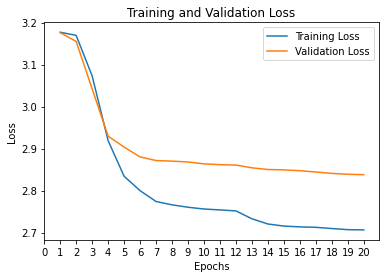

In [19]:
from numpy import arange

# Visualize the loss 
epochs = range(1, 21)
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, validation_loss_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 21, 1))
 
plt.legend(loc='best')
plt.show()